# Strength function: an introduction

We saw that the exact completeness relation using the bound and continuum states can be efficiently approximated by a discrete basis set made of continuum states. Still, this is not a quantity of physical interest: it could be interesting to find such a quantity which strongly relies on the continuum states in order to replace them by Siegert states. 

The first example we will provide in this tutorial concerns the **strength function (SF)**:

$S(k) = - \frac{1}{\pi} \Im \left\langle g | G(k) | g \right\rangle$

where $G$ is the **Green's function** (or resolvent) of the Hamiltonian of the considered system and $g$ is a test function.

The exact Green's function may be written as follows:

$G(k) = \sum_b \frac{\left| \varphi_b \right\rangle \left\langle \varphi_b \right|}{k^2/2 - {k_b}^2/2}
      + \sum_{p = \pm} \int_0^{+\infty} \text{d} k_1 \frac{\left| \varphi_p \right\rangle \left\langle \varphi_p \right|}{k^2/2 - {k_1}^2/2}$
      
where the first sum runs over the bound states of the system (of wavenumber $k_b$), while the second one runs over the continuum states of wavenumber ($k_1$), which can be even (subscript $+$) or odd (subscript $-$).

We will compare this exact result with the one obtained by using the approximated Green's function given by the **Mittag-Leffler expansion** (MLE):

$G_{MLE}(k) = \sum_{S = a, b, c, d} \frac{\left| \varphi_S \right) \left( \varphi_S \right|}{k_S (k - k_S)}$
      
where the sum runs over all the Siegert states of the system (of wavenumber $k_S$, where $S$ represents a type of Siegert states: $a$ for anti-bound, $b$ for bound, $c$ for resonant or capturing states and $d$ for anti-resonant or decaying states).

We still consider the case of a 1D Square-Well potential, where the Siegert and continuum states are known analytically. It is therefore possible to get the exact strength function and to compare it to the MLE of the SF.

## Initialization: create the basis sets

### Import some modules and classes

In [1]:
# Make the notebook aware of some of the SiegPy module classes
from siegpy import SWPBasisSet, Rectangular, Gaussian, SWPotential
# Other imports
import numpy as np
import matplotlib.pyplot as plt

### Create a basis-set made of Siegert states only

In [2]:
siegerts = SWPBasisSet.from_file("siegerts.dat", nres=25)

### Create an exact basis-set, made of bound and continuum states

The bound states are taken from the Siegert basis set while the continuum states are discretized over a grid of real wavenumbers.

In [3]:
# Find the potential of the basis set made of Siegert states
potential = siegerts.potential
l = potential.width

# Find some continuum states
k_max = abs(siegerts.resonants.wavenumbers[-1])
h_k = 0.01
continuum = SWPBasisSet.find_continuum_states(potential, k_max, h_k)

# Create the exact basis set
exact = siegerts.bounds + continuum

**This step is actually optional when running a real strength function calculation (but is mandatory for the purpose of this notebook), as using a dense basis set over a large range of wavenumbers leads to prohibitively long computation times to get a converged strength function.** It is actually better to build a continuum basis set "on the fly" while computing each desired point of the strength function.

### Define test functions to evaluate the strength function.

The strength function (SF) is evaluated using a test function $g$. For the MLE of the SF to hold, this test function must lie in region $II$ (inside the potential, where $|x| \leq l/2$). The cases of a Gaussian test function and of a rectangular test function are studied.

In [4]:
x_c = 0.0  # Center of the test functions
a = l/2.  # Width of the rectangular function
sigma = l/20.  # Width of the Gaussian
test_gauss = Gaussian(sigma, x_c)  # Gaussian test function
test_rect = Rectangular.from_width_and_center(a, x_c)  # Rectangular test function

### Create the grid of wavenumbers where the strength function is evaluated

`kgrid` defines the wavenumber grid used for plotting. It is not mandatory to keep the same dense grid used to initialize the continuum states. It is even rather strongly advised to make this grid as small as possible: this saves computation time, since a costly integration over the continuum states is performed for each point $k$ in `kgrid` to evaluate the exact strength function .

In [5]:
step = 0.1  # Grid-step for plotting
k_max = 10  # Maximal wavenumber for plotting
kgrid = np.arange(step, k_max, step)

## Case 1: strength function for a Gaussian test function

Both exact and approximate strength functions are calculated, the latter being very cheap to obtain, whereas the exact SF takes a long time due to the integrations over the continuum, that must extend to a large `k_max` and be very dense (small `h_k`). It is very difficult to get a converged result with respect to the amelioration of the continuum states basis (*i.e.* with smaller `h_k` and larger `k_max`). Learning from the numerical convergence of this scheme, it was possible to produce another scheme allowing a better convergence (using smaller `eta` and `h_k`) within a reasonable amount of time, by avoiding the need to discretize a dense basis set of continuum states over the whole range of wavenumbers.

Note that there is no need to use a basis made of continuum states to compute the exact strength function "on the fly". Some default values for `h_k`, `eta` and a tolerance parameters are passed to this method. They were found to give a good compromise between accuracy and speed for a large number of cases. Such default values for `eta` and `h_k` do not allow to get an exact SF using the other method in a limited amount of time. 

Compared to the exact calculations, computing the MLE of the SF is cheap.

In [6]:
SF_MLE_gauss = siegerts.MLE_strength_function(test_gauss, kgrid)
SF_exact_gauss = exact.exact_strength_function(test_gauss, kgrid)
SF_exact_gauss_other = siegerts.exact_strength_function_OTF(test_gauss, kgrid)

The MLE of the SF reproduces perfectly the exact converged SF (evaluated with the minimal "on the fly" continuum basis set). The exact SF using the whole continuum basis set is not converged yet, even though it gives rather accurate results, especially for large $k$.

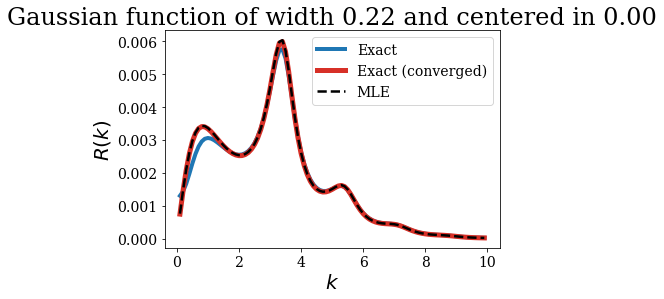

In [7]:
# Compare the exact SF to the MLE of the SF
plt.plot(kgrid, SF_exact_gauss, lw=4, label='Exact')
plt.plot(kgrid, SF_exact_gauss_other, color='#d73027', lw=5, label='Exact (converged)')
plt.plot(kgrid, SF_MLE_gauss, color='#000000', ls='--', label='MLE')
plt.xlabel("$k$")
plt.ylabel("$R(k)$")
plt.title(repr(test_gauss))
plt.legend()
plt.show()

The same plot can be obtained by applying the `plot_strength_function` method to a basis set made of Siegert states. The exact converged result are then computed. This method requires the same parameters: a test function and a wavenumber grid. You may also pass some other arguments, such as the filename `file_save` to save the plot in a file.

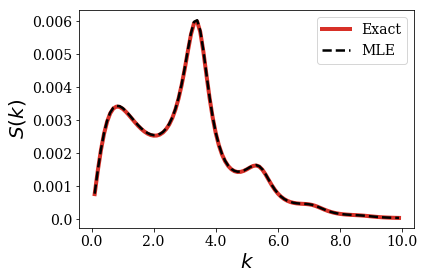

In [8]:
siegerts.plot_strength_function(test_gauss, kgrid, file_save='SF_gauss_centered.pdf')

The main advantage of using the MLE of the strength function is that you gain substantial physical information on which resonance causes a particular peak of the strength function. Each peak of the strength function is indeed related to one particular resonant couple (in blue). The only exception is that the first peak correponds to the sum of the bound and anti-bound states contribution (in red). 

This is triggered by the optional `nres` parameter, that specifies the number of resonant couples that are used. Note that if `nres` is set to 0, then only the peak corresponding to the bound and anti-bound states contributions to the strength function is plotted.

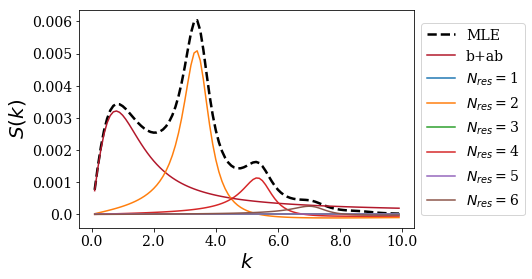

In [9]:
siegerts.plot_strength_function(test_gauss, kgrid, exact=False, nres=6)

As you can see, the position **and** the shape of a particular peak is related to one particular resonance.

## Case 2: strength function for a rectangular test function

The same study can be done using the previously defined rectangular test function:

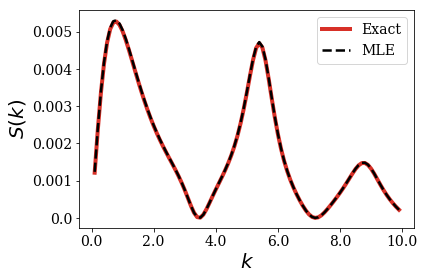

In [10]:
siegerts.plot_strength_function(test_rect, kgrid, file_save='SF_rect_centered_half_width.pdf')

Regarding the relation between one peak to a resonance couple, it may happen that some resonant/anti-resonant couples  contributions are purely negative. A particular example is when the rectangular function is centered and its width is half the potential width, as is the case here. Half of these couples give a contribution leading to a peak, while the contributions of the other half lead to zeros of the strength function:

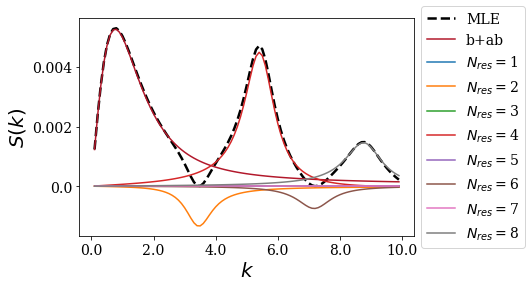

In [11]:
siegerts.plot_strength_function(test_rect, kgrid, exact=False, nres=8)

Another "funny" example is when the width of the rectangular function gets close to the width of the potential: the contribution of each resonant couple is then negative, as if it was "boring" through the bound/anti-bound states contribution. In this particular case, only the zeros of the strength function are related to the resonant couples:

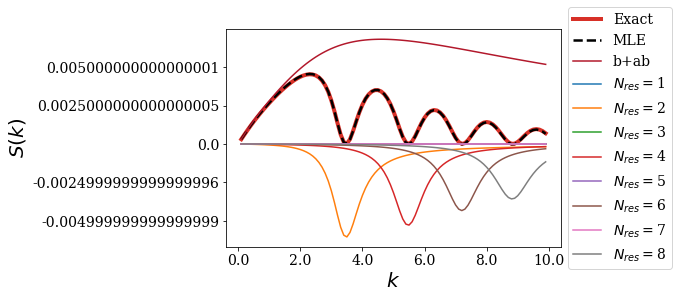

In [12]:
rect = Rectangular.from_width_and_center(0.999*l, x_c)
siegerts.plot_strength_function(rect, kgrid, nres=8)

Remember that the test function is close to the border of region $II$. This means that this is a problematic case for the completeness relation but, as you can see, it is not problematic at all when it comes to reproduce the strength function.

This concludes the first notebook about the strength function using Siegert states. You saw that the strength function can be well approximated by using the Mittag-Leffler exapnsion of the Green's function, even in some cases that were problematic for the completeness relation. By using Siegert states, you may also gain some physical information, by relating a peak to a particular resonance. 

You should now be able to compute the strength function of any 1D SW potential using any analytic test function available, such as the Gaussian and rectangular functions. 